## A demo for removing baselines using RWSS


#### Load data

In [1]:
#install.packages('prospectr')
library("e1071")
library(prospectr)

rawdata = read.csv("thumbNail.csv", header = F)
rawdata = rawdata[-(1:2),-1]
rawdata2 = matrix(rep(0,nrow(rawdata)*ncol(rawdata)), nrow = nrow(rawdata))
for(i in 1:ncol(rawdata))
{
  rawdata2[,i] = as.numeric(as.character(rawdata[,i]))
}
rawdata2 = rawdata2[,-which(apply(rawdata2,2,sum)==0)]
rawdata = rawdata2
y = rawdata[,1]
rawdata = rawdata[,-1]
data1 = rawdata[,800:1800]

prospectr version 0.2.1 -- 'seville'

check the github repository at: http://github.com/l-ramirez-lopez/prospectr



**Note:** The example dataset can be downloaded from: https://www.kaggle.com/codina/raman-spectroscopy-of-diabetes

#### Data visualization

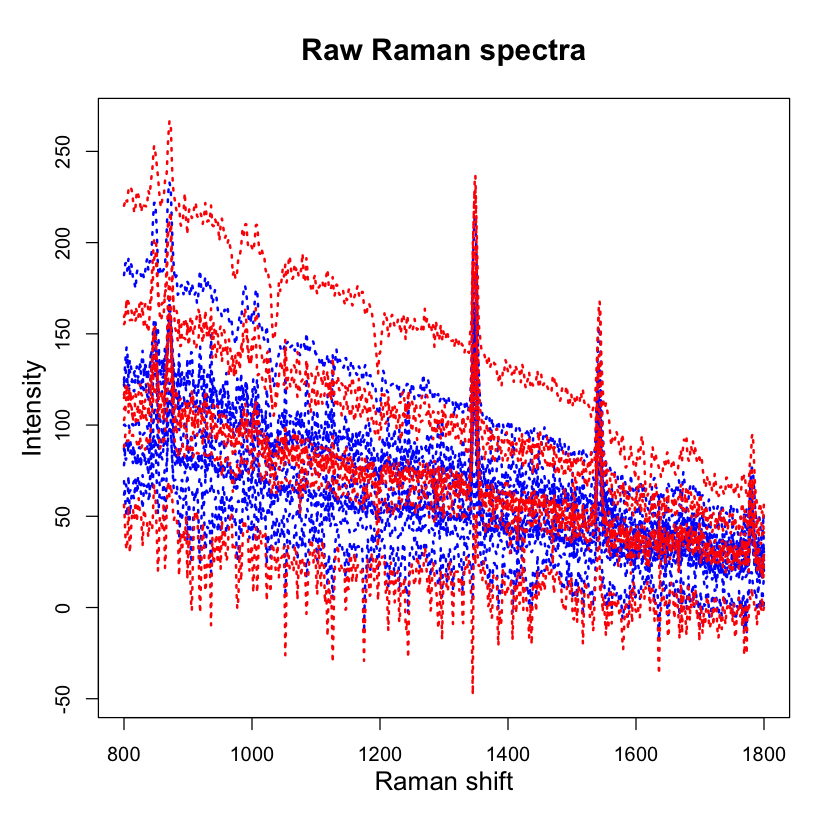

In [2]:
plot(800:1800, data1[1,], lty=3,lwd=2, type="n", xlab="", ylab="",
     ylim = c(min(data1),max(data1)))
for(i in 1:nrow(data1))
{
  if(i<=11)( lines(800:1800, data1[i,],  type='l', lty=3, lwd=2, col = "blue"))
  if(i>11)( lines(800:1800, data1[i,],  type='l', lty=3, lwd=2, col = "red"))
}
mtext('Raman shift', side = 1, line = 2.2, cex=1.3)
mtext('Intensity', side = 2, line = 2.2, cex=1.3)
title('Raw Raman spectra', cex.main=1.5)

#### Preprocessing: removing noise 

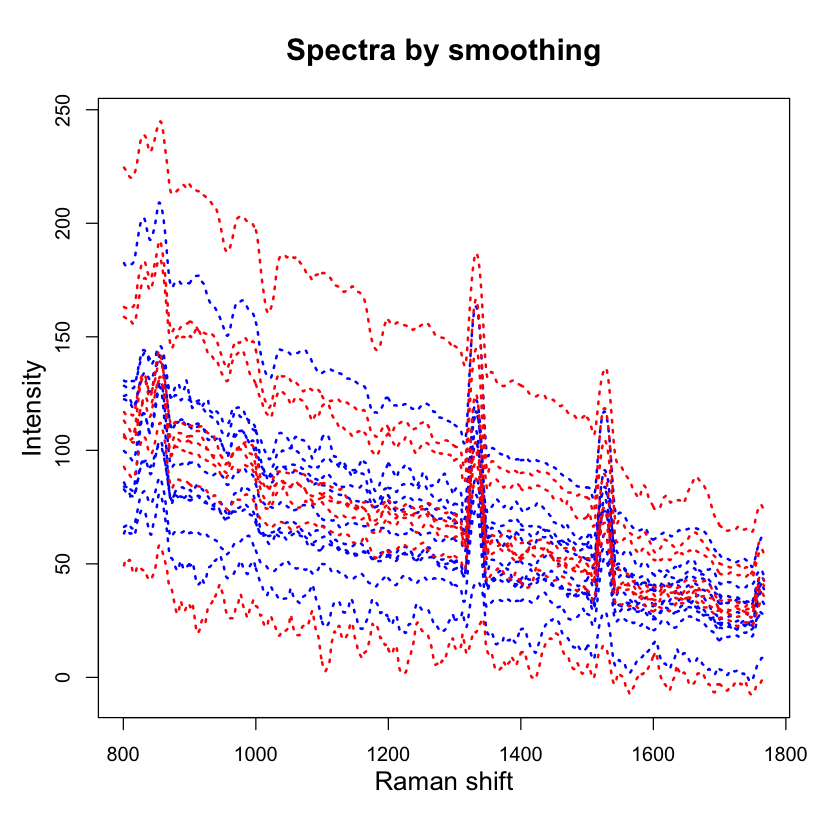

In [3]:
#########################################
########removing noise##################
smoother = 35
l = 270 # for airPLS
lambda1 = 0.0001; b = 320; lambda2 = 0.001
data_rn <- matrix(rep(0,20*967), nrow = 20)
for(i in 1:20){
  data_rn[i,] <- savitzkyGolay(data1[i,], 0, 3, 35)
}

plot(801:(800+dim(data_rn)[2]), data_rn[1,], lty=3,lwd=2, type="n", xlab="", ylab="",
     ylim = c(min(data_rn),max(data_rn)))
for(i in 1:nrow(data_rn))
{
  if(i<=11)(lines(801:(800+dim(data_rn)[2]), data_rn[i,],  type='l', lty=3,lwd=2,col="blue"))
  if(i>11)(lines(801:(800+dim(data_rn)[2]), data_rn[i,],  type='l', lty=3,lwd=2,col="red"))
}
mtext('Raman shift', side = 1, line = 2.2, cex=1.3)
mtext('Intensity', side = 2, line = 2.2, cex=1.3)
title('Spectra by smoothing', cex.main=1.5)

In [4]:
RWSS <- function(x, lambda1, criterion1 = 0.01, b, lambda2 = lambda1, criterion2 = 0.05){
  m <- length(x)
  wi <- rep(1, m)
  ss <- smooth.spline(x, lambda = lambda1, all.knots = TRUE, w = wi)
  z <- ss$y
  r_org <- x - z
  sigma_MAV <- median(abs(r_org)) / 0.6745
  r <- r_org / sigma_MAV
  flag <- sum(abs(r[r<0]))
  niter = 0
  while ( 1 ){
    wi <- ifelse(r < 0, 1, ifelse(1 - (r / b) ^ 2 > 0, 1 - (r / b) ^ 2, 0))
    ss <- smooth.spline(x, lambda = lambda1, all.knots = TRUE, w = wi)
    z <- ss$y
    r_org <- x - z
    sigma_MAV <- median(abs(r_org[r_org < b * sigma_MAV])) / 0.6745
    r <- r_org / sigma_MAV
    if (abs(flag/sum(abs(r[r<0])) - 1) < criterion1){
      break
    }
    flag <- sum(abs(r[r<0]))
  }
  
  
  # WSS parts
  # pre-baseline 
  b <- z
  # initialize the weights
  weights <- rep(1, m)
  # redo the smoothing.spline fitting
  ss_re <- smooth.spline(b, lambda = lambda2, all.knots = TRUE, w = weights)
  z <- ss_re$y
  
  residuals <- log((b - z)^2)
  variance <- smooth.spline(residuals, cv = TRUE, all.knots = TRUE)
  flag <- sum(abs(b - z))
  index = which((b-z) < 0)
  
  while(1){
    weights <- 1 / exp(variance$y)
    weights <- weights/sum(weights) # scale
    weights[index] = 1-weights[index]
    
    ss_re <- smooth.spline(b, lambda = lambda2, all.knots = TRUE, w = weights)
    res2 <- (b - ss_re$y)^2
    residuals <- log(ifelse(res2 == 0, min(res2[res2 != 0]), res2))
    variance <- smooth.spline(residuals, cv = TRUE, all.knots = TRUE)
    if( abs(sum(abs(z - ss_re$y)) / flag - 1) < criterion2 ){break}
    flag <- sum(abs(z - ss_re$y))
    z <- ss_re$y
    
    index = which((b-z) < 0)
    
    if (length(index)<0.1*length(b)) {break}
  }
  return(z)
}

#### Removing baselines using the RWSS

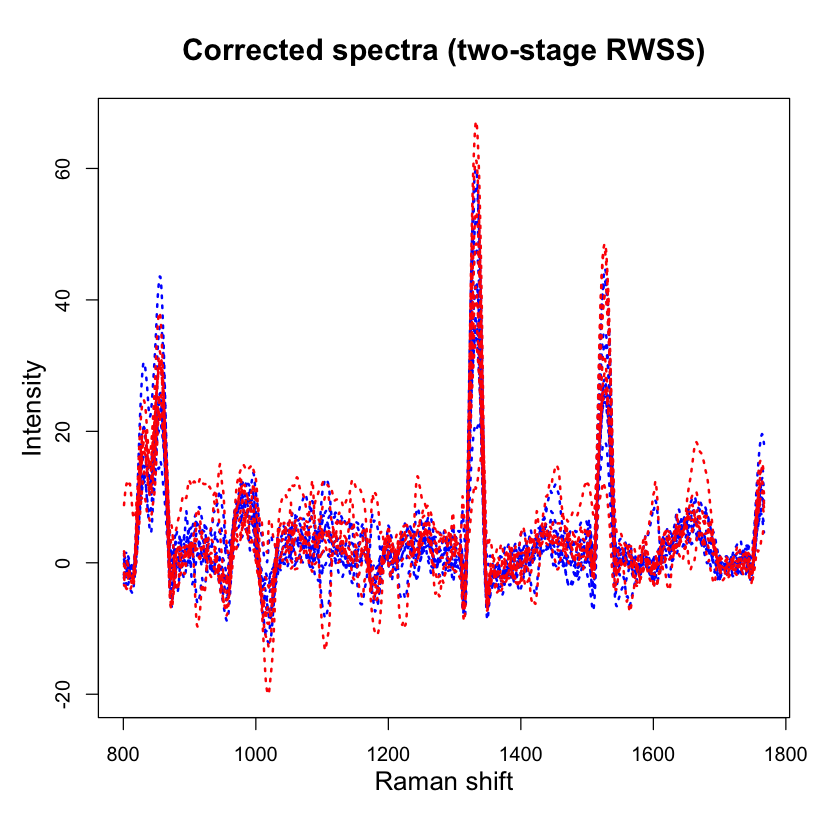

In [5]:
x_RWSS <- data_rn
for(i in 1:20){
  x_RWSS[i,] <- x_RWSS[i,] - RWSS(data_rn[i, ], lambda1 = lambda1, b = b, lambda2 = lambda2)
}

plot(801:(800+dim(data_rn)[2]), x_RWSS[1,], lty=3,lwd=2, type="n", xlab="", ylab="",
     ylim = c(min(x_RWSS),max(x_RWSS)))
for(i in 1:nrow(x_RWSS))
{
  if(i<=11)(lines(801:(800+dim(data_rn)[2]), x_RWSS[i,],  type='l', lty=3,lwd=2,col="blue"))
  if(i>11)(lines(801:(800+dim(data_rn)[2]), x_RWSS[i,],  type='l', lty=3,lwd=2,col="red"))
}
mtext('Raman shift', side = 1, line = 2.2, cex=1.3)
mtext('Intensity', side = 2, line = 2.2, cex=1.3)
title('Corrected spectra (two-stage RWSS)', cex.main=1.5)

**Reference**

Guevara, E., Torres-Galván, J. C., Ramírez-Elías, M. G., Luevano-Contreras, C., & González, F. J. (2018). Use of Raman spectroscopy to screen diabetes mellitus with machine learning tools. Biomedical Optics Express, 9(10), 4998–5010. https://doi.org/10.1364/BOE.9.004998